(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import ActiveInference as AI

# Import DataFrames
import DataFrames as DF

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# Ising models - Monte Carlo simulations

This notebook accompanies a series of notes based on David MacKay's book
chapters on the Ising model. In this notebook, we will explore the Ising model
via Monte Carlo simulations.

## The Ising model

Ising models are a simple model of ferromagnetism. The model consists of an
array of spins that can be in one of two states, up or down (or +1 or -1). The
spins are magnetically coupled to their neighbors with two possible types of
couplings: 
- ferromagnetic (like spins want to align) or 
- antiferromagnetic (like spins want to anti-align).

Let the state $\underline{x}$ of an ising model with $N$ spins be a vector in
which each element $x_n$ is the state of the $n$-th spin. If two spins are
neighbors, we write $(m, n) \in \mathcal{N}$. The coupling energy for a pair of
spins is defined as
$$
J_{mn} = \begin{cases}
J & \text{if } (m, n) \in \mathcal{N}\\
0 & \text{otherwise}
\end{cases}.
\tag{1}
$$
The energy of any state $\underline{x}$, also called the Hamiltonian, is defined
as
$$
E(\underline{x}; J, H) = - \frac{1}{2} \left[
    \sum_{m, n} J_{mn} x_m x_n + H \sum_n x_n,
\right],
\tag{2}
$$
where $H$ is an externally applied field. If $J > 0$ the model is ferromagnetic,
and if $J < 0$ the model is antiferromagnetic. The $1/2$ factor comes from the
double counting of the energy of each pair of spins, once as $(m, n)$ and once
as $(n, m)$. At equilibrium temperature $T$, the probability of a state
$\underline{x}$ is given by the Boltzmann distribution
$$
P(\underline{x} \mid \beta, J, H) = \frac{1}{\mathcal{Z}} \exp\left(
    -\beta E(\underline{x}; J, H)
\right),
\tag{3}
$$
where $\beta = 1 / k_B T$ is the inverse temperature, and $\mathcal{Z}$ is the
partition function, defined as
$$
\mathcal{Z} = \sum_{\underline{x}} \exp\left(
    -\beta E(\underline{x}; J, H)
\right).
\tag{4}
$$

## Monte Carlo simulations

### Gibbs sampling

Let us study a two-dimensional planar Ising model with periodic boundary using a
simple Gibbs sampling Monte Carlo simulation. The algorithm is as follows:

1. Initialize the spins randomly.
2. Select a spin $n$ at random.
3. The probability of having spin $x_n = 1$ is should be given by the state of
   the other spins and the temperature. This probability is computed as
    $$
    P(x_n = 1 \mid b_n) = \frac{1}{1 + \exp(-2 \beta b_n)},
    \tag{5}
    $$
    where $b_n$ is the local field acting on spin $n$, given by
    $$
    b_n = \sum_{m \in \mathcal{N}_n} J_{mn} x_m + H.
    \tag{6}
    $$
    The factor of 2 appears because the states are ${\pm 1}$ and not ${0, 1}$.
4. Generate a random number $r$ between 0 and 1. If $r < P(x_n = 1 \mid b_n)$,
   set $x_n = 1$, otherwise set $x_n = -1$.
5. Repeat steps 2-4 for a number of iterations.

After enough iterations, the system will reach equilibrium.

#### Rectangular lattice

For our simulation, we will consider a $L \times L$ square lattice with periodic
boundary conditions. Let's start by defining a function to compute the energy of
a given state of this lattice.

In [2]:
"""
    E_rectangular(x̲::Matrix, J::Number, H::Number)

Compute the energy of a configuration in the Ising model on a rectangular
lattice.

# Arguments
- `x̲::Matrix`: a matrix representing the spin configuration. Each element is +1
  or -1.

# Optional Keyword Arguments
- `J`: the coupling constant. Positive for ferromagnetic coupling, negative for
  antiferromagnetic.
- `H`: the external magnetic field.

# Returns
- The energy of the configuration.

# Notes
- The function uses periodic boundary conditions.
- The energy is computed as -J ∑ x̲[i, j] x̲[i', j'] - H ∑ x̲[i, j], where the
  first sum is over all pairs of neighboring spins and the second sum is over
  all spins.
"""
function E_rectangular(x̲::Matrix; J=1.0f0, H=0.0f0)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)
    # Initialize the energy to zero
    energy = 0.0f0

    # Compute the coupling energy between neighboring spins
    for i in 1:m
        for j in 1:n
            # Apply periodic boundary conditions
            # If i > 1, then im1 = i - 1, else im1 = m (the last row)
            im1 = i > 1 ? i - 1 : m
            # If i < m, then ip1 = i + 1, else ip1 = 1 (the first row)
            ip1 = i < m ? i + 1 : 1
            # If j > 1, then jm1 = j - 1, else jm1 = n (the last column)
            jm1 = j > 1 ? j - 1 : n
            # If j < n, then jp1 = j + 1, else jp1 = 1 (the first column)
            jp1 = j < n ? j + 1 : 1

            # Subtract the energy contribution from the neighbor below
            energy -= J * x̲[i, j] * x̲[ip1, j]
            # Subtract the energy contribution from the neighbor to the right
            energy -= J * x̲[i, j] * x̲[i, jp1]
        end # for j
    end # for i

    # Subtract the energy contribution from the external field
    energy -= H * sum(x̲)

    # Return the total energy
    return energy
end

E_rectangular

Next, we need to define a function to compute the local field acting on a spin.

In [3]:
"""
    local_field_rectangular(n::Int, x̲::Matrix, J, H)

Compute the local magnetic field at a given spin in the Ising model on a
rectangular lattice.

# Arguments
- `n::Int`: the linear index of the spin.
- `x̲::Matrix`: a matrix representing the spin configuration. Each element is +1
  or -1.

# Optional Keyword Arguments
- `J`: the coupling constant. Positive for ferromagnetic coupling, negative for
  antiferromagnetic.
- `H`: the external magnetic field.

# Returns
- The local magnetic field at the spin.

# Notes
- The function uses periodic boundary conditions.
- The local field is computed as J ∑ x̲[i', j'] + H, where the sum is over the
  neighboring spins of the given spin.
"""
function local_field_rectangular(
    n::Int, x̲::Matrix; J=1.0f0, H=0.0f0
)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)

    # Convert the linear index to row and column indices
    i, j = Tuple(CartesianIndices(x̲)[n])

    # Apply periodic boundary conditions
    # If i > 1, then im1 = i - 1, else im1 = m (the last row)
    im1 = i > 1 ? i - 1 : m
    # If i < m, then ip1 = i + 1, else ip1 = 1 (the first row)
    ip1 = i < m ? i + 1 : 1
    # If j > 1, then jm1 = j - 1, else jm1 = n (the last column)
    jm1 = j > 1 ? j - 1 : n
    # If j < n, then jp1 = j + 1, else jp1 = 1 (the first column)
    jp1 = j < n ? j + 1 : 1

    # Compute the local field at the spin
    # This is the sum of the spins of the neighboring spins, multiplied by the coupling constant, plus the external field
    bₙ = J * (x̲[im1, j] + x̲[ip1, j] + x̲[i, jm1] + x̲[i, jp1]) + H

    # Return the local field
    return bₙ
end

local_field_rectangular

With these two functions in hand, we can now define a function to perform the
Gibbs sampling.

In [4]:
"""
    gibbs_sampling!(
        x̲::Matrix{<:Number}, n_iter::Int; 
        J::Number=1, H::Number=0, β::Number=1, 
        local_field::Function=local_field_rectangular
    )

Perform Gibbs sampling on a spin configuration in the Ising model.

# Arguments
- `x̲::Matrix`: a matrix representing the initial spin configuration. Each
  element is +1 or -1.
- `n_iter::Int`: the number of iterations to perform.

## Optional Keyword Arguments
- `J::Number`: the coupling constant. Positive for ferromagnetic coupling,
  negative for antiferromagnetic.
- `H::Number`: the external magnetic field.
- `β::Number`: the inverse temperature.
- `local_field::Function`: a function that computes the local magnetic field at
  a given spin.

# Returns
- The final spin configuration after `n_iter` iterations of Gibbs sampling.

# Notes
- The function modifies the input `x̲` in place.
- The function uses the Gibbs sampling algorithm, which is a type of Markov
  chain Monte Carlo (MCMC) algorithm.
- The local field is computed using the `local_field` function, which should
  take as arguments the linear index of the spin, the spin configuration matrix,
  the coupling constant, and the external field.
"""
function gibbs_sampling!(
    x̲::Matrix,
    n_iter::Int;
    J=1.0f0,
    H=0.0f0,
    β=1.0f0,
    local_field::Function=local_field_rectangular
)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)
    # Compute the total number of spins
    N = m * n

    # Perform Gibbs sampling for `n_iter` iterations
    for iter in 1:n_iter
        # Select a random spin
        spin_idx = rand(1:N)

        # Compute the local field acting on the selected spin
        b_n = local_field(spin_idx, x̲; J=J, H=H)

        # Compute the probability of the spin being +1
        # This is given by the logistic function of the local field, scaled by the inverse temperature
        p_up = 1 / (1 + exp(-2 * β * b_n))

        # Generate a random number
        r = rand()

        # Update the spin according to the generated number and the computed
        # probability If the number is less than the probability, the spin is
        # set to +1, otherwise it is set to -1
        if r < p_up
            x̲[spin_idx] = 1
        else
            x̲[spin_idx] = -1
        end # if r < p_up
    end # for iter

    # Return the final spin configuration
    return x̲
end # function

gibbs_sampling!

Let's test the Gibbs sampling function by initializing a random state and
running the Gibbs sampling for a few iterations.

In [5]:
Random.seed!(42)

# Define latice size
m, n = 16, 16
# Define number of iterations
n_iter = 1_000
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Copy the initial state to the current state
x = deepcopy(x_init)

# Perform Gibbs sampling
gibbs_sampling!(x, n_iter)

16×16 Matrix{Int8}:
 1   1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1
 1  -1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1

Let's show the initial and final states of the lattice.

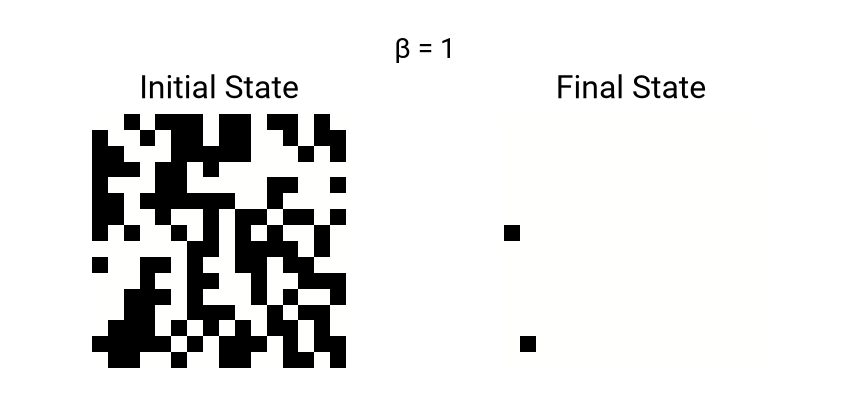

In [6]:
# Initialize figure
fig = Figure(size=(425, 200))

# Add global GridLayout
gl = fig[1, 1] = GridLayout()

# Add axes to the figure
axes = [
    Axis(gl[1, i], aspect=AxisAspect(1))
    for i in 1:2
]

# Plot the initial state
heatmap!(
    axes[1],
    x_init,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[1].title = "Initial State"

# Plot the final state
heatmap!(
    axes[2],
    x,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[2].title = "Final State"

# Hide decorations
hidedecorations!.(axes)

# Add title to the figure
Label(
    gl[1, :, Top()],
    "β = 1",
    valign=:bottom,
    font=:bold,
    padding=(0, 0, 25, 0)
)

fig

For this low temperature, the system is in a ferromagnetic phase, where the
spins tend to align with each other. The initial random configuration evolves
towards a more ordered state, with large domains of aligned spins.

Let's now increase the temperature and see how the system behaves.

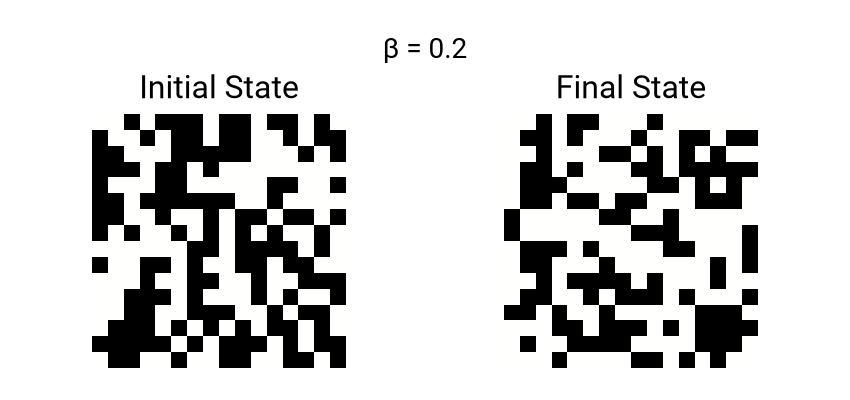

In [7]:
Random.seed!(42)

# Define inverse temperature
β = 1 / 5
# Define latice size
m, n = 16, 16
# Define number of iterations
n_iter = 1_000
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Copy the initial state to the current state
x = deepcopy(x_init)

# Perform Gibbs sampling
gibbs_sampling!(x, n_iter; β=β)

# Initialize figure
fig = Figure(size=(425, 200))

# Add global GridLayout
gl = fig[1, 1] = GridLayout()

# Add axes to the figure
axes = [
    Axis(gl[1, i], aspect=AxisAspect(1))
    for i in 1:2
]

# Plot the initial state
heatmap!(
    axes[1],
    x_init,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[1].title = "Initial State"

# Plot the final state
heatmap!(
    axes[2],
    x,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[2].title = "Final State"

# Hide decorations
hidedecorations!.(axes)

# Add title to the figure
Label(
    gl[1, :, Top()],
    "β = $(round(β, digits=2))",
    valign=:bottom,
    font=:bold,
    padding=(0, 0, 25, 0)
)

fig

As expected, at higher temperatures (lower β), the spins are more likely to flip, leading to a more disordered state.

Let's look at a series of temperatures for a larger grid.

In [8]:
Random.seed!(42)
# Define temperatures to test
T = [1, 2, 3, 4, 8, 16]
# Define β values
β_vals = 1 ./ T

# Define latice size
m, n = 100, 100
# Define number of iterations
n_iter = 10_000_000
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Make a copy of the initial state for each temperature
x = [deepcopy(x_init) for _ in β_vals]

# Perform Gibbs sampling for each temperature
for (i, β) in enumerate(β_vals)
    gibbs_sampling!(x[i], n_iter; β=β)
end

Let's visualize the final states for each temperature.

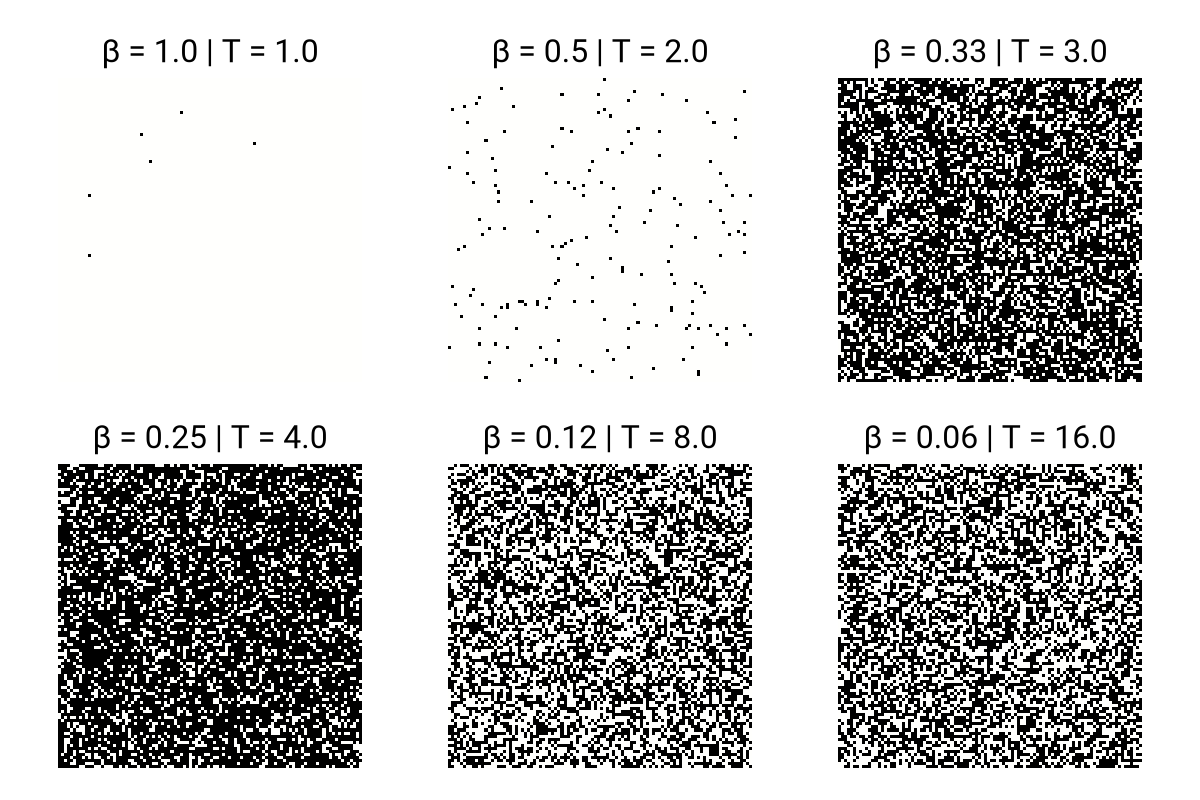

In [9]:

# Initialize figure
fig = Figure(size=(600, 400))

# Define number of rows and columns for the grid layout
rows = 2
cols = 3

# Add global GridLayout
gl = fig[1, 1] = GridLayout()

# Loop through each temperature and plot the final state
for (i, β) in enumerate(β_vals)
    # Define row and column indices for the subplot
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to the figure
    ax = Axis(gl[row, col], aspect=AxisAspect(1))

    # Plot the final state
    heatmap!(
        ax,
        x[i],
        colormap=ColorSchemes.grays,
        colorrange=(-1, 1),
        showaxis=false,
        showticks=false,
        transpose=true,
    )

    # Add title to the subplot
    ax.title = "β = $(round(β, digits=2)) | T = $(round(1 / β, digits=2))"
    # Hide decorations
    hidedecorations!(ax)
end # for

fig

We can see that somewhere between temperature 2 and 3, the system goes from
being highly ordered to highly disordered. This is indicative of a phase
transition.

## Phase transitions

One of the most interesting aspects of the Ising model is the presence of phase
transitions. Specifically, the two-dimensional Ising model has a phase
transition on the magnetization at a critical temperature $T_c$. Below $T_c$,
the system is in a ferromagnetic phase, where the spins tend to align with each
other. Above $T_c$, the system is in a paramagnetic phase, where the spins are
disordered.

To study the phase transition, we can compute the magnetization of the system as
a function of temperature. The magnetization is defined as
$$
m = \frac{1}{N} \sum_n^N x_n,
\tag{7}
$$
where $N$ is the number of spins. We can also study the mean energy per spin as
well as the fluctuations in this energy. For this, we need to repeat the Gibbs
sampling for a number of iterations.

In [10]:
Random.seed!(42)
# Define range of temperatures in log scale
T = 10 .^ range(-1, stop=log10(50), length=50)
# Compute the corresponding β values
β_vals = Float32.(1 ./ T)
# Define latice size
m, n = 100, 100
# Defie number of iterations for Gibbs sampling
n_iter = 5_000_000
# Define number of iterations to reach equilibrium
n_cyc = 500
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Initialize empty list to store the results
df_list = []

# Loop through each temperature
Threads.@threads for i in 1:length(β_vals)
    # Extract β value
    β = β_vals[i]
    # Initialize array to store the energy values
    energy = zeros(n_cyc)
    # Initialize array to save magnetization values
    magnetization = zeros(n_cyc)
    # Loop through each cycle
    for cyc in 1:n_cyc
        # Make copy of the initial state
        x = deepcopy(x_init)
        # Perform Gibbs sampling to reach equilibrium
        gibbs_sampling!(x, n_iter; β=β)
        # Compute the energy of the final state
        energy[cyc] = E_rectangular(x)
        # Compute the magnetization of the final state
        magnetization[cyc] = sum(x) / length(x)
    end # for cyc
    # Create temporary DataFrame to store the results for the current
    # temperature
    df_tmp = DF.DataFrame(
        β=β,
        T=1 / β,
        energy=energy,
        magnetization=magnetization,
    )
    # Append the temporary DataFrame to the main DataFrame
    push!(df_list, df_tmp)
end # for β

# Append all DataFrames into a single DataFrame
df = DF.vcat(df_list...)

first(df, 5)

Row,β,T,energy,magnetization
,Float32,Float32,Float64,Float64
1,3.62537,0.275834,-20000.0,1.0
2,3.62537,0.275834,-20000.0,1.0
3,3.62537,0.275834,-20000.0,1.0
4,3.62537,0.275834,-20000.0,1.0
5,3.62537,0.275834,-20000.0,1.0


Let's look at the magnetization and energy as a function of temperature.

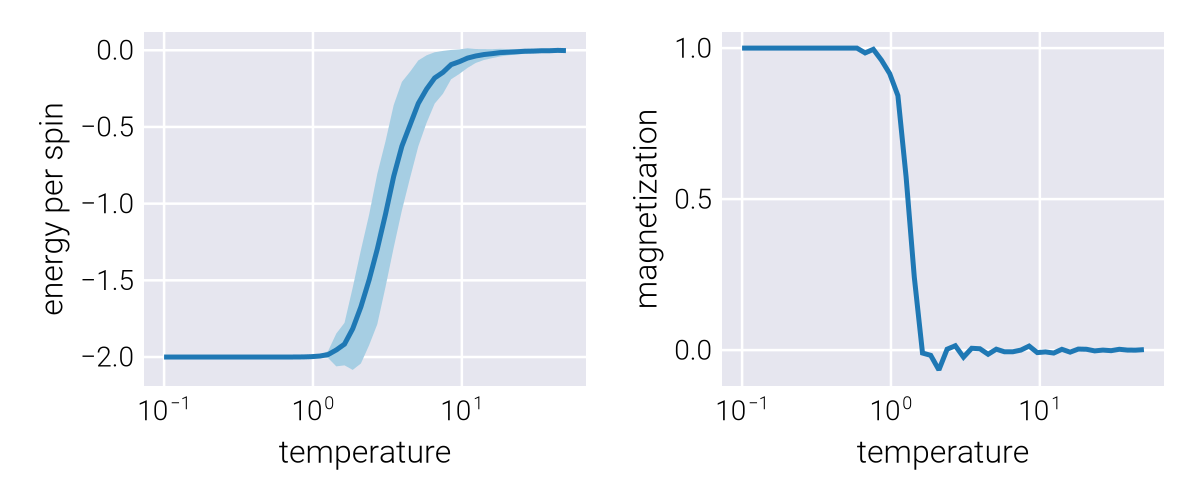

In [11]:
# Initialize figure
fig = Figure(size=(600, 250))

# Add axis for energy plot
ax1 = Axis(
    fig[1, 1],
    xlabel="temperature",
    ylabel="energy per spin",
    xscale=log10,
    aspect=AxisAspect(1.25)
)

# Compute mean and std energy for quantities
df_en = DF.sort!(
    DF.combine(
        DF.groupby(df, :T),
        :energy => StatsBase.mean => :energy_mean,
        :energy => StatsBase.std => :energy_std,
        :magnetization => StatsBase.mean => :magnetization_mean,
        :magnetization => StatsBase.std => :magnetization_std,
    ),
    :T
)


# Plot energy std as fill between
band!(
    ax1,
    df_en.T,
    (df_en.energy_mean .- df_en.energy_std) ./ length(x_init),
    (df_en.energy_mean .+ df_en.energy_std) ./ length(x_init),
    color=ColorSchemes.Paired_10[1],
)
# Plot mean energy
lines!(
    ax1,
    df_en.T,
    df_en.energy_mean ./ length(x_init),
    linewidth=2.5,
    color=ColorSchemes.Paired_10[2],
)


#  Add axis for magnetization plot
ax2 = Axis(
    fig[1, 2],
    xlabel="temperature",
    ylabel="magnetization",
    xscale=log10,
    aspect=AxisAspect(1.25)
)

# Plot mean magnetization
lines!(
    ax2,
    df_en.T,
    df_en.magnetization_mean,
    linewidth=2.5,
    color=ColorSchemes.Paired_10[2],
)

fig

From these plots we can clearly see the phase transition. The magnetization
suddenly drops to zero at the critical temperature, indicating a transition from
a ferromagnetic to a paramagnetic phase.

Another way to observe the phase transition is by looking at the heat capacity
as a function of temperature. One can show that the heat capacity is related to
the fluctuations in the energy as
$$
C = \frac{1}{k_B T^2} \left(
    \langle E^2 \rangle - \langle E \rangle^2
\right) = k_B \beta^2 \text{Var}(E).
\tag{8}
$$
For a phase transition, we expect the heat capacity to peak at the critical
temperature.

Let's plot both the energy fluctuations and the heat capacity as a function of
temperature.

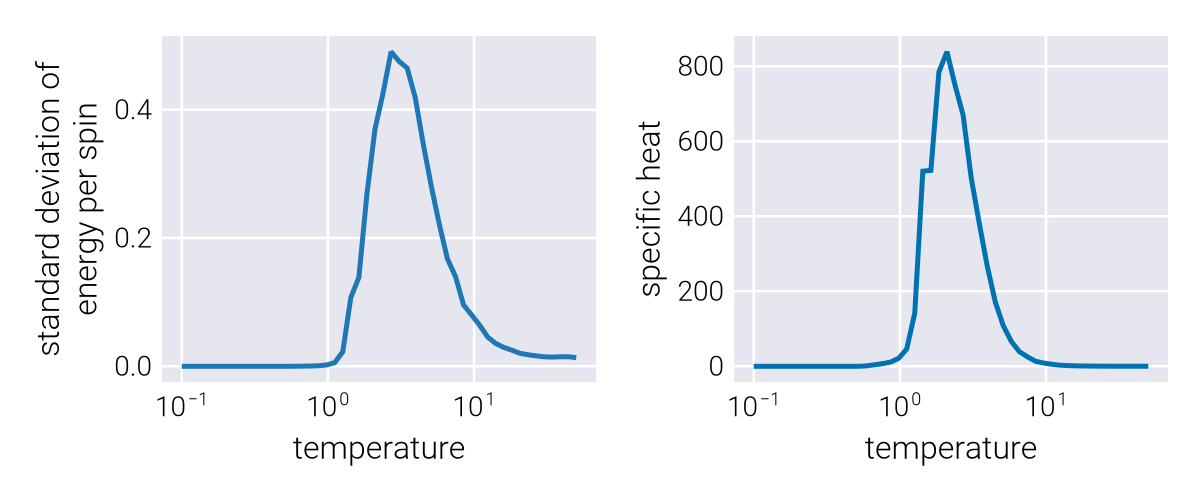

In [12]:
# Initialize figure
fig = Figure(size=(600, 250))

# Add axis for standard deviation of energy plot
ax1 = Axis(
    fig[1, 1],
    xlabel="temperature",
    ylabel="standard deviation of\nenergy per spin",
    xscale=log10,
    aspect=AxisAspect(1.25)
)

# Plot std in energy per spin
lines!(
    ax1,
    df_en.T,
    df_en.energy_std ./ length(x_init),
    linewidth=2.5,
    color=ColorSchemes.Paired_10[2],
)

# Add axis for specific heat plot
ax2 = Axis(
    fig[1, 2],
    xlabel="temperature",
    ylabel="specific heat",
    xscale=log10,
    aspect=AxisAspect(1.25)
)

# Plot specific heat
lines!(
    ax2,
    df_en.T,
    df_en.energy_std ./ df_en.T .^ 2,
    linewidth=2.5,
)

fig

As expected, the heat capacity peaks at the critical temperature, indicating a
phase transition from a ferromagnetic to a paramagnetic phase.